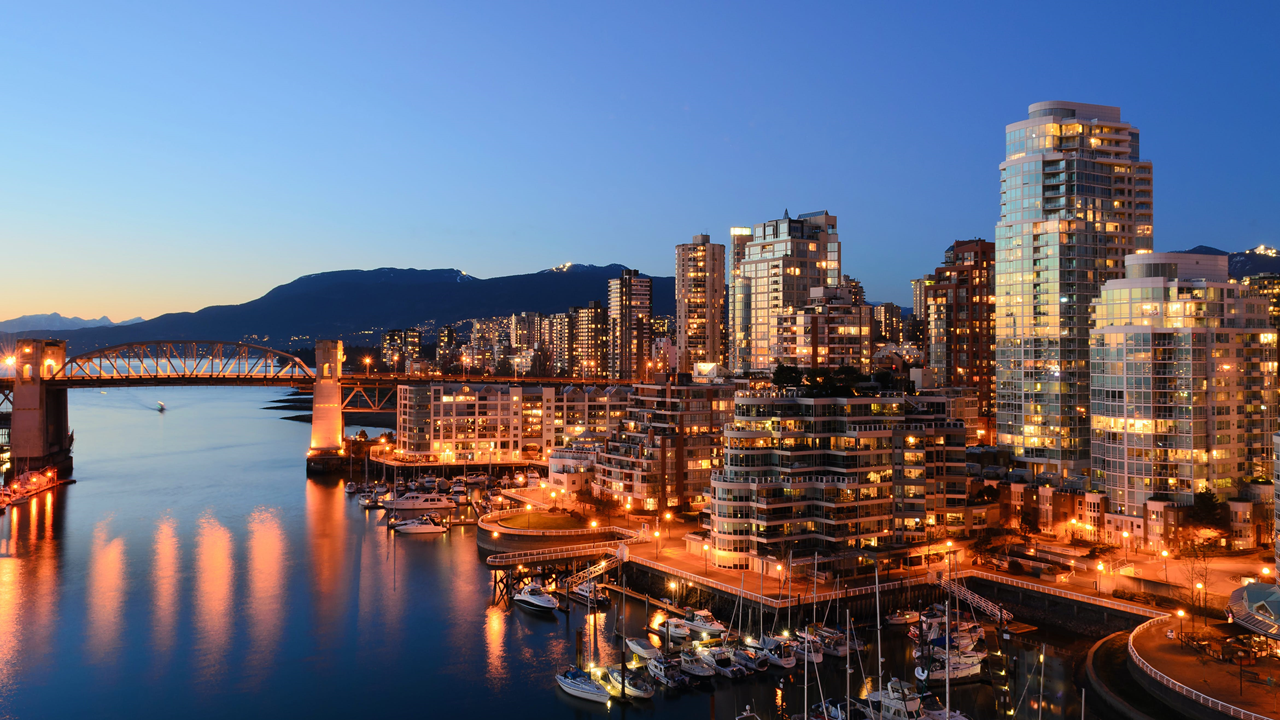
# Capstone Project - The Battle of the Neighborhoods (Week 2)
### High Class Arabian food Resturant startup in Vancouver
_Prepared by:Zyad Elmekki (zyadabuharaz@hotmail.com)_

## Introduction:
The scope for this study to get most suitable location in Vancouver city, Canada to build a resturant that reflects Arabian foods to western communities with high class level of service.

In order to get the optimum location we will use available online data to build our approach based on safety and crime levels in the city. We will try to locate the shop in safest neighborhood with good resturants area to enrich food options for customers.

## Data:
1. Data Collection:
  * Collect city data (boroughs and neighborhoods) using list of officially categorized boroughs in Vancouver from Wikipedia.
  * Vancouver Crimes records (Verified dataset from Kaggle)
2. Data Preparation:
  * Boroughs and neighborhoods shall be cleaned and prepared as data frame with needed coordinates
  * Crime records dataset also will be cleaned and mapped to prepared data in first step

## Methodology and Working:

Lets Import required libararies:

In [2]:
import numpy as np
import pandas as pd

#install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage
from opencage.geocoder import OpenCageGeocode

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Libraries imported


In [4]:
#Import Vancouver crimes data
vc_crimes = pd.read_csv('https://raw.githubusercontent.com/RamanujaSVL/Coursera_Capstone/master/vancouver_crime_records_2018.csv', index_col=None)

#Dropping unnecessary columns
vc_crimes.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)
vc_crimes.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vc_crimes.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


In [8]:
#Now lets prepare neighbourhoods data

column_names = ['Neighbourhood', 'Borough'] 
vc_neigh_bor = pd.DataFrame(columns=column_names)
vc_neigh_bor['Neighbourhood'] = vc_crimes['Neighbourhood'].unique()
neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vc_neigh_bor['Neighbourhood']):
  vc_neigh_bor.loc[vc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)
vc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vc_neigh_bor['Neighbourhood']),"Borough Count",len(vc_neigh_bor['Borough'].unique()))
vc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


#### Now lets merge prepared dataframes

In [10]:
vc_boroughs_crime = pd.merge(vc_crimes,vc_neigh_bor, on='Neighbourhood')
vc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,Central
1,Break and Enter Commercial,2018,6,16,18,West End,Central
2,Break and Enter Commercial,2018,12,12,0,West End,Central
3,Break and Enter Commercial,2018,3,2,3,West End,Central
4,Break and Enter Commercial,2018,3,17,11,West End,Central


In [11]:
#Dropping invalid data
vc_boroughs_crime.dropna(inplace=True)
vc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

In [14]:
#Categorizing data through pivot table and prepare the data
vc_crime_cat = pd.pivot_table(vc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)

vc_crime_cat.reset_index(inplace = True)
vc_crime_cat.columns = vc_crime_cat.columns.map(''.join)
vc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)
vc_crime_cat = vc_crime_cat.head(4)
vc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


In [16]:
vc_crime_neigh = pd.pivot_table(vc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)

vc_crime_neigh.reset_index(inplace = True)
vc_crime_neigh.columns = vc_crime_neigh.columns.map(''.join)
vc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vc_crime_cat.describe()

,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
count,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,506.250000,599.250000,1430.25000,1236.750000,3736.500000,539.750000,286.500000,3.250000,368.500000,8707.000000
std,354.409721,488.189427,997.26572,1060.087221,2723.536977,353.955153,226.117226,3.304038,227.060198,5801.870618
min,49.000000,156.000000,187.00000,88.000000,483.000000,36.000000,71.000000,1.000000,111.000000,1182.000000
25%,314.500000,187.500000,843.25000,544.000000,2249.250000,450.000000,186.500000,1.000000,263.250000,5698.500000
50%,594.500000,599.000000,1627.00000,1185.000000,3796.000000,633.000000,235.000000,2.000000,351.500000,9802.000000
75%,786.250000,1010.750000,2214.00000,1877.750000,5283.250000,722.750000,335.000000,4.250000,456.750000,12810.500000
max,787.000000,1043.000000,2280.00000,2489.000000,6871.000000,857.000000,605.000000,8.000000,660.000000,14042.000000


In [21]:
#Lets see top 5 neighborhoods

vc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
22,West End,230,72,460,455,1461,203,77,1,72,3031
11,Mount Pleasant,205,124,353,493,822,232,67,0,100,2396
19,Strathcona,160,124,527,81,821,108,76,2,88,1987
9,Kitsilano,106,165,320,154,755,189,51,1,61,1802


#### Data Exploration:

visualizing crime reports in different boroughs to identify the safest borough and normalize the neighborhoods of that borough. We will Use the resulting data and find 10 most common venues in each neighborhood.

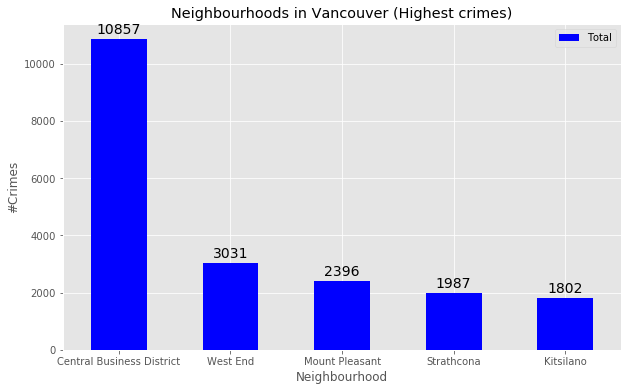

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
23,West Point Grey,18,71,50,11,157,32,11,0,22,372
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
17,South Cambie,22,42,41,38,111,19,8,0,11,292
18,Stanley Park,6,2,8,0,109,14,3,0,12,154
12,Musqueam,0,4,3,0,4,2,2,0,2,17


In [72]:
#Lets plot the data
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]
per_neigh.set_index('Neighbourhood',inplace = True)
ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0, color ='b')
ax.set_ylabel('#Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver (Highest crimes)')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#Lets see least neighbourhoods
crime_neigh_low = vc_crime_neigh.tail(5)
crime_neigh_low

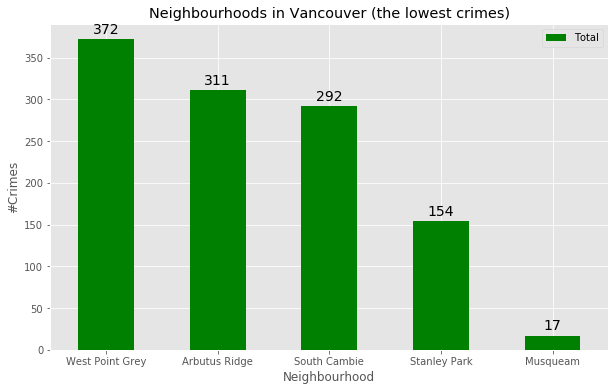

In [28]:
#lets see them
per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0, color='g')

ax.set_ylabel('#Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver (the lowest crimes)')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [29]:
vc_crime_cat = pd.pivot_table(vc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)

vc_crime_cat.reset_index(inplace = True)
vc_crime_cat.columns = vc_crime_cat.columns.map(''.join)
vc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
vc_crime_cat = vc_crime_cat.head(4)
vc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


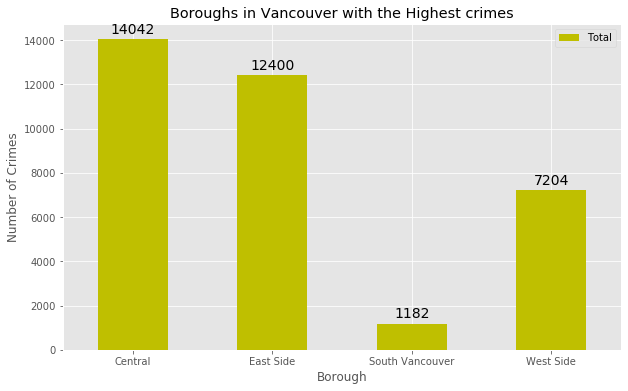

In [32]:
per_borough = vc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0, color='y')

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#### Based on the data South Vancouver hase the least crimes, although its not feasable for business, so we shall go for **west side**

#### Lets examine the west side:

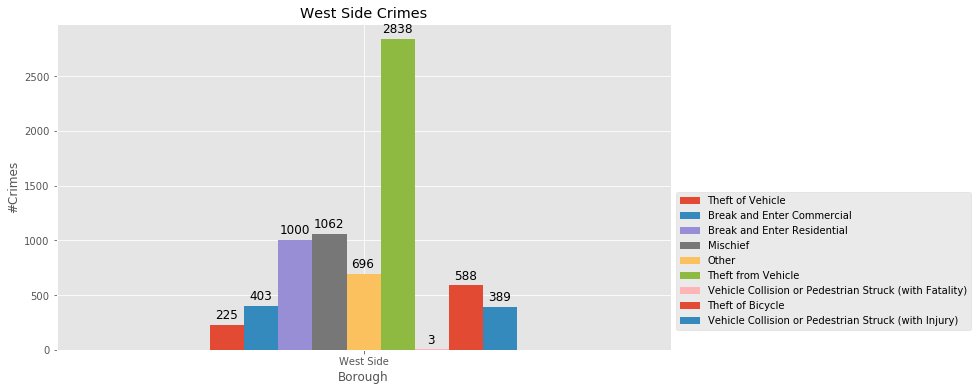

In [35]:
vc_ws_df = vc_crime_cat[vc_crime_cat['Borough'] == 'West Side']
vc_ws_df = vc_ws_df.sort_values(['Total'], ascending = True, axis = 0)
vc_ws = vc_ws_df[['Borough','Theft of Vehicle', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle','Vehicle Collision or Pedestrian Struck (with Fatality)','Theft of Bicycle',
                 'Vehicle Collision or Pedestrian Struck (with Injury)']]


vc_ws.set_index('Borough',inplace = True)
ax = vc_ws.plot(kind='bar', figsize=(11, 6), rot=0)
ax.set_ylabel('#Crimes')
ax.set_title('West Side Crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 12
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

#### Now let have west side neigbourhoods locations:

In [39]:
vc_ws_neigh = vc_boroughs_crime
vc_ws_neigh = vc_ws_neigh[vc_ws_neigh['Borough'] == 'West Side']
vc_ws_neigh.reset_index(inplace=True, drop=True)

print('Number of Neighbourhoods in West Side Borough are', len(vc_ws_neigh['Neighbourhood'].unique()), ', as below:')

Latitude = []
Longitude = []
Borough = []
Neighbourhood = vc_ws_neigh['Neighbourhood'].unique()

key = '830323b5ca694362904814ff0a11b803'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('West Side')
     
    
ws_neig_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
ws_neig_geo = pd.DataFrame(data=ws_neig_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

ws_neig_geo

Number of Neighbourhoods in West Side Borough are 10 , as below:


,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


In [47]:
# Lets see them on the map

address = 'Vancouver, BC, Canada'
location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

vc_map = folium.Map(location=[latitude, longitude], zoom_start=13)
# add markers to map
for lat, lng, borough, neighborhood in zip(ws_neig_geo['Latitude'], ws_neig_geo['Longitude'], ws_neig_geo['Borough'], ws_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(vc_map)  
    
vc_map

In [53]:
#lets prepare foursquare and get the data
#Four Square Credentials

CLIENT_ID = 'J1GHJYREYH0E2TNMICYHKZ5OWTJMDRBDPUG5454RC4QWU2GP'
CLIENT_SECRET =  '2S1I3ZG54XLJRU2AJWLEEIQ42PUXC0E2XSQ2V1HIGFVLNLHI'
VERSION = '20200720'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)
vc_ws_venues = getNearbyVenues(names=ws_neig_geo['Neighbourhood'],
                                   latitudes=ws_neig_geo['Latitude'],
                                   longitudes=ws_neig_geo['Longitude']
                                  )

Shaughnessy
Fairview
Oakridge
Marpole
Kitsilano
Kerrisdale
West Point Grey
Arbutus Ridge
South Cambie
Dunbar-Southlands


In [54]:
vc_ws_venues.groupby('Neighbourhood').count().drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Category'], axis = 1)

,Venue
Neighbourhood,
Arbutus Ridge,5
Dunbar-Southlands,6
Fairview,26
Kerrisdale,40
Kitsilano,48
Marpole,31
Oakridge,8
Shaughnessy,3
South Cambie,15


### Modelling:

To help stakeholders choose the right neighborhood within a borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use K-Means clustering to address this problem so as to group data based on existing venues which will help in the decision making process.

In [56]:
#We shall now start modelling using onehat to analyze neighborhoods

vc_onehot = pd.get_dummies(vc_ws_venues[['Venue Category']], prefix="", prefix_sep="")
vc_onehot['Neighbourhood'] = vnc_ws_venues['Neighbourhood'] 
fixed_columns = [vc_onehot.columns[-1]] + list(vc_onehot.columns[:-1])
vc_onehot = vc_onehot[fixed_columns]
vc_onehot.head()

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,...,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfall,Wine Shop,Yoga Studio
0,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fairview,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
vc_ws_grouped = vc_onehot.groupby('Neighbourhood').mean().reset_index()
vc_ws_grouped

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,...,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfall,Wine Shop,Yoga Studio
0,Arbutus Ridge,0.000000,0.000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000000
1,Dunbar-Southlands,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000000
2,Fairview,0.000000,0.000,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.038462,0.038462,0.000,0.000000
3,Kerrisdale,0.000000,0.000,0.025000,0.000000,0.025000,0.025000,0.000000,0.000000,0.025,...,0.050000,0.000000,0.025000,0.000,0.000000,0.000,0.025000,0.000000,0.000,0.000000
4,Kitsilano,0.041667,0.000,0.020833,0.000000,0.083333,0.000000,0.000000,0.020833,0.000,...,0.020833,0.020833,0.041667,0.000,0.020833,0.000,0.000000,0.000000,0.000,0.020833
5,Marpole,0.000000,0.000,0.000000,0.000000,0.000000,0.032258,0.032258,0.000000,0.000,...,0.000000,0.000000,0.032258,0.000,0.000000,0.000,0.064516,0.000000,0.000,0.000000
6,Oakridge,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.125000,0.000000,0.000,0.000000
7,Shaughnessy,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000000
8,South Cambie,0.000000,0.000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.066667,0.000000,0.000,0.000000
9,West Point Grey,0.000000,0.025,0.025000,0.000000,0.025000,0.025000,0.025000,0.000000,0.025,...,0.000000,0.000000,0.000000,0.025,0.050000,0.025,0.000000,0.000000,0.025,0.025000


In [58]:
#Lets explore top 5 venues

num_top_venues = 5

for hood in vc_ws_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = vc_ws_grouped[vc_ws_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
            venue  freq
0   Grocery Store   0.2
1          Bakery   0.2
2  Nightlife Spot   0.2
3             Spa   0.2
4       Pet Store   0.2


----Dunbar-Southlands----
                venue  freq
0    Sushi Restaurant  0.33
1         Coffee Shop  0.17
2  Italian Restaurant  0.17
3   Indian Restaurant  0.17
4      Ice Cream Shop  0.17


----Fairview----
              venue  freq
0       Coffee Shop  0.15
1  Asian Restaurant  0.08
2              Park  0.08
3      Camera Store  0.04
4    Sandwich Place  0.04


----Kerrisdale----
                venue  freq
0         Coffee Shop  0.10
1  Chinese Restaurant  0.10
2            Pharmacy  0.05
3            Tea Room  0.05
4    Sushi Restaurant  0.05


----Kitsilano----
                 venue  freq
0               Bakery  0.08
1  American Restaurant  0.04
2           Restaurant  0.04
3       Ice Cream Shop  0.04
4  Japanese Restaurant  0.04


----Marpole----
                   venue  freq
0       Sushi Restaurant  0.10


In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = vc_ws_grouped['Neighbourhood']

for ind in np.arange(vc_ws_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vc_ws_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Nightlife Spot,Bakery,Grocery Store,Pet Store,Spa,Gas Station,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant
1,Dunbar-Southlands,Sushi Restaurant,Coffee Shop,Italian Restaurant,Indian Restaurant,Ice Cream Shop,Gas Station,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant
2,Fairview,Coffee Shop,Asian Restaurant,Park,Pharmacy,Sushi Restaurant,Salon / Barbershop,Sandwich Place,Falafel Restaurant,Camera Store,Malay Restaurant
3,Kerrisdale,Chinese Restaurant,Coffee Shop,Pharmacy,Tea Room,Sushi Restaurant,Sandwich Place,Fast Food Restaurant,Noodle House,Dessert Shop,Mediterranean Restaurant
4,Kitsilano,Bakery,American Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ice Cream Shop,French Restaurant,Sushi Restaurant,Food Truck,Thai Restaurant


In [62]:
# set number of clusters
kclusters = 5

vc_grouped_clustering = vc_ws_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vc_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
vancouver_merged = ws_neig_geo
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
vancouver_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,West Side,49.251863,-123.138023,4,Park,Bus Stop,French Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food Truck,Gas Station
1,Fairview,West Side,49.264113,-123.126835,0,Coffee Shop,Asian Restaurant,Park,Pharmacy,Sushi Restaurant,Salon / Barbershop,Sandwich Place,Falafel Restaurant,Camera Store,Malay Restaurant
2,Oakridge,West Side,49.230829,-123.131134,0,Israeli Restaurant,Convenience Store,Sandwich Place,Café,Pharmacy,Fast Food Restaurant,Sushi Restaurant,Vietnamese Restaurant,Grocery Store,Falafel Restaurant
3,Marpole,West Side,49.209223,-123.136150,0,Sushi Restaurant,Dessert Shop,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Bubble Tea Shop,Liquor Store,Dim Sum Restaurant,Plaza,Falafel Restaurant
4,Kitsilano,West Side,49.269410,-123.155267,0,Bakery,American Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ice Cream Shop,French Restaurant,Sushi Restaurant,Food Truck,Thai Restaurant


In [63]:
#Lets view them in map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Lets Examine clusters:

In [74]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[0] + list(range(5, vancouver_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Fairview,Coffee Shop,Asian Restaurant,Park,Pharmacy,Sushi Restaurant,Salon / Barbershop,Sandwich Place,Falafel Restaurant,Camera Store,Malay Restaurant
2,Oakridge,Israeli Restaurant,Convenience Store,Sandwich Place,Café,Pharmacy,Fast Food Restaurant,Sushi Restaurant,Vietnamese Restaurant,Grocery Store,Falafel Restaurant
3,Marpole,Sushi Restaurant,Dessert Shop,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Bubble Tea Shop,Liquor Store,Dim Sum Restaurant,Plaza,Falafel Restaurant
4,Kitsilano,Bakery,American Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ice Cream Shop,French Restaurant,Sushi Restaurant,Food Truck,Thai Restaurant
5,Kerrisdale,Chinese Restaurant,Coffee Shop,Pharmacy,Tea Room,Sushi Restaurant,Sandwich Place,Fast Food Restaurant,Noodle House,Dessert Shop,Mediterranean Restaurant
6,West Point Grey,Café,Japanese Restaurant,Sporting Goods Shop,Pizza Place,Sushi Restaurant,Coffee Shop,Pub,Vegetarian / Vegan Restaurant,Bar,Gastropub


In [75]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[0] + list(range(5, vancouver_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,South Cambie,Coffee Shop,Shopping Mall,Vietnamese Restaurant,Cantonese Restaurant,Bank,Malay Restaurant,Grocery Store,Gift Shop,Sushi Restaurant,Bus Stop


In [76]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 2, vancouver_merged.columns[[0] + list(range(5, vancouver_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Dunbar-Southlands,Sushi Restaurant,Coffee Shop,Italian Restaurant,Indian Restaurant,Ice Cream Shop,Gas Station,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant


In [77]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[0] + list(range(5, vancouver_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Arbutus Ridge,Nightlife Spot,Bakery,Grocery Store,Pet Store,Spa,Gas Station,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant


In [78]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 4, vancouver_merged.columns[[0] + list(range(5, vancouver_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,Park,Bus Stop,French Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food Truck,Gas Station


## Results
In order to have the Arabian resturant to be established in safest neighbourhood, within area of interest to succeed, we concluded 10 neighborhoods and listed the common venues sorted to give better picture.


## Discussion
* Objective of business case to help investors find suitable place for opening Arabian resturant in Vancouver city to bring the culture of arabic food to this city in a different way.

* Our case was build based on safety mainly and also based on most common venues study. where we concluded 10 most optimum locations in the city.
* Its still open that another studies can be carried out to enhance filterization of locations based on other aspects (like community, age, race, etc.)

**Finally** i hope the notebook was easy to read and helpful, and i shall be glad to receive your comments and Constructive criticism those shall help me improve my skills better,
# Thank You